## Geospatial Analysis of Thomas Fire Burn Area (2017)

![Thomas Fire at Faria Beach](https://news.ucsb.edu/sites/default/files/styles/large_2340x1212/public/2023-11/Thomas-Fire-Faria-Beach-cropped-Noozhawk.jpg?itok=YGnOu1vN)

Photo Credit: [Ray Ford, Noozhawk](https://news.ucsb.edu/2023/021283/thomas-fire-research-reveals-ash-can-fertilize-oceans)

### About
In December 2017, the Thomas Fire burned through 281,000 acres of land spread through both Santa Barbara and Ventura counties. According to the California Department of Forestry and Fire Protection, the Thomas Fire destroyed 1,063 residential & commercial structures and injured 2 fire personnel. The impacts of the fire were not only devasting for humans, but also for the surrounding environment. The Thomas Fire devasted wildlife, displaced many ecological communities, and caused poor quality for an extended period of time. 

The **motivation** for this post is to demonstrate how to use geospatial analysis in Python to analyze the environmental impacts of the Thomas Fire. We'll first analyze air quality data 



### Github Repository

The full analysis is located in this Github repository:
[https://github.com/katleyq/eds220-thomas-fire-final](https://github.com/katleyq/eds220-thomas-fire-final)

### Highlights
In this analysis of the Thomas Fire, we'll accomplish the following:
- Time series analysis and visualization of air quality index (AQI) of affected burn area
- Raster analysis of landsat data to visualize burn areas using false color image
- Analysis of landcover statistics to visualize ecosystems affected by fire


### Data

This repository utilizes the following datasets:

1) **Air Quality Index (AQI)**: This data was retrieved from the [US Environmental Protection Agency](https://www.epa.gov). It contains air quality data throughout the US, and we subset this dataset for Santa Barbara County.

2) **Thomas Fire Perimeter Data**: This data was retrieved from US governement's data catalogue. It contains spatial data regarding fire perimeters and associated metadata. We subset this data for the 2017 Thomas Fire. (Original Source:  [California Fire Perimeter Data](https://catalog.data.gov/dataset/california-fire-perimeters-all-b3436))

3) **Landsat Data**: This data was retrieved from the Microsoft Planetary Computer Data Catalogue, pre-processed by Dr. Carmen Galaz-Garcia, and stored on the MEDS computational server. This data contains multispectral data for the area of interest. (Original Source:  [Microsoft Planetary Computer Data Catalogue](https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2))


### Import libraries

The first step of our analysis is to import all relevant libraries. We'll use the following libraries throughout this analysis:

In [1]:
import pandas as pd # Dataframe manipulation
import matplotlib.pyplot as plt # Plotting
import os # To construct file paths
import xarray as xr # To work with arrays
import rioxarray as rioxr # To work with netCDFs
import geopandas as gpd # To maniplate spatial data frames
from shapely.geometry import box  # To create polygon bounding box
from matplotlib_scalebar.scalebar import ScaleBar # for map scalebar
import matplotlib.patches as mpatches # for map legend
from matplotlib.offsetbox import AnchoredText # for map compass

## **Part 1** - Time Series Analysis of Air Quality Index (AQI) of Thomas Fire Burn Area

In this first part, we will


### Load Data

In [2]:
# Read in data
aqi_17 = pd.read_csv('https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2017.zip', compression='zip')
aqi_18 = pd.read_csv('https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2018.zip', compression='zip')

### Data Cleaning and Visualizing

In [3]:
# Combine aqi_17 and aqi_18 observations
aqi = pd.concat([aqi_17, aqi_18])

# Simplify column names
aqi.columns = (aqi.columns
                  .str.lower()
                  .str.replace(' ','_'))
               
# Locate observations where county_name == Santa Barbara then store it as a copy in aqi_sb
aqi_sb = aqi.loc[aqi.county_name=='Santa Barbara'].copy()
               
               
# Convert date column of aqi_sb to datetime type
aqi_sb.date = pd.to_datetime(aqi_sb.date)
               
# Set the data column as the index then reassign it back to aqi_sb
aqi_sb = aqi_sb.set_index('date')

In [3]:
# Calculate AQI rolling average over 5 day window
rolling_average = aqi_sb.aqi.rolling(window = 5).mean()
               
# Create new column in aqi_sb called five_day_average and attach rolling_average series
aqi_sb['five_day_average'] = rolling_average
               

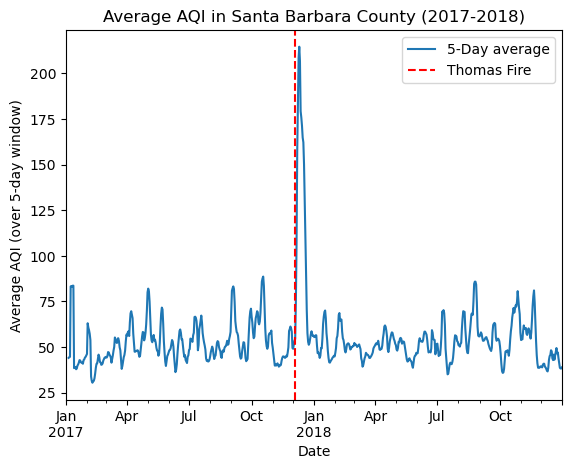

In [3]:
# Create line plot for AQI levels over time for Santa Barbara (2017-2018)
plot = (aqi_sb.plot(kind='line', y='five_day_average', label = "5-Day average"))

# Set title, xlabel, and ylabel for plot
plot.set_title("Average AQI in Santa Barbara County (2017-2018)")
plot.set_xlabel("Date")
plot.set_ylabel("Average AQI (over 5-day window)")

# Add a vertical line on December 4, 2017 which was beginning of Thomas Fire
plt.axvline(x=pd.to_datetime("2017-12-04"), color='red', linestyle='--', label = "Thomas Fire")
plt.legend()

The plot above shows a 5-day rolling average of air quality index in Santa Barbara County from January 2017 to October 

## **Part 2** - Using landsat data to visualize Thomas Fire burn area by creating false color image

In this section, we'll

In [13]:
# Load California Fire Perimeter shapefile
thomas_fire = gpd.read_file("data/thomas_fire.shp")

# Load landsat data
landsat = rioxr.open_rasterio("data/landsat8-2018-01-26-sb-simplified.nc")

In [5]:
# Convert data to 2 dimensions then drop the band variable
landsat = landsat.squeeze().drop_vars('band')

In [6]:
# Print out CRS of landsat and thomas_fire CRSs
print(f"**Landsat CRS** = {landsat.rio.crs}")
print('----')
print(f"**Thomas Fire CRS** = {thomas_fire.crs}")

**Landsat CRS** = EPSG:32611
----
**Thomas Fire CRS** = EPSG:3857


In [7]:
# Print the height and width of the landsat data 
print('Height: ', landsat.rio.height)
print('Width: ', landsat.rio.width)

Height:  731
Width:  870


In [8]:
# Calculate aspect ratio for plotting landsat data
landsat_aspect_ratio = landsat.rio.width / landsat.rio.height

In [9]:
# Convert thomas_fire CRS to match landsat CRS
thomas_fire = thomas_fire.to_crs(landsat.rio.crs)

In [10]:
# Verify that landsat CRS is the same as thomas_fire crs before moving onto next code
assert landsat.rio.crs == thomas_fire.crs

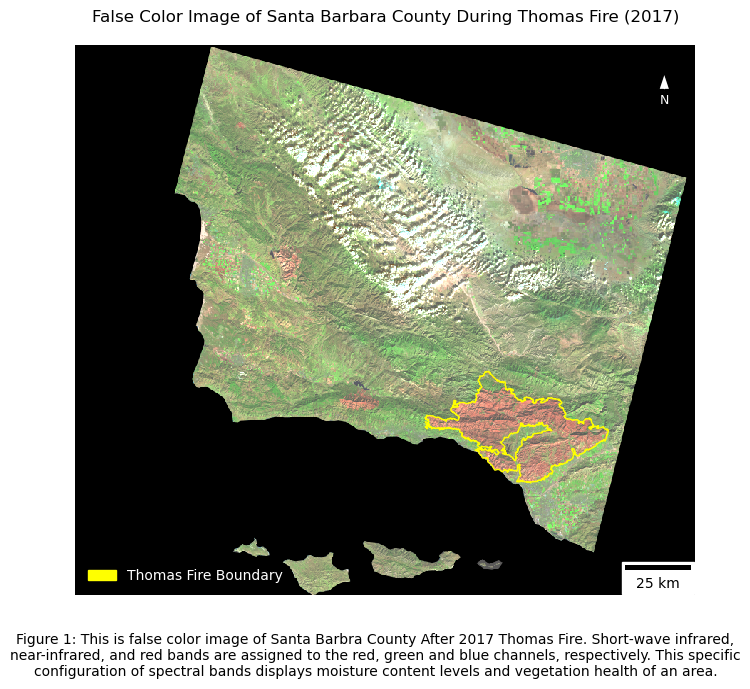

In [11]:
# Initialize a new plot with correct aspect ratio
fig, ax = plt.subplots(figsize = (8, 6*landsat_aspect_ratio))

# Remove axes
ax.axis('off')

# Overlay thomas_fire polygon
thomas_fire.plot(ax = ax,
                 color = 'none',
                edgecolor = 'yellow', 
                linewidth = 1)

# Plot shortwave infrared, near infrared, and red bands of landsat data to RGB channels respectively
landsat[['swir22', 'nir08', 'red']].to_array().plot.imshow(ax = ax, 
                                                           robust = True)
# Add title
ax.set_title('False Color Image of Santa Barbara County During Thomas Fire (2017)')

# Create scalebar
scalebar = ScaleBar(1,  # Scale in units per pixel
                    units='m',  # Set units to meters
                    location='lower right', 
                    scale_loc='bottom')  

# Add scalebar created above to plot
ax.add_artist(scalebar)

# Create legend for Thomas Fire Boundary
ax.legend(handles = [mpatches.Patch(color='yellow',
                          label='Thomas Fire Boundary')], 
          loc = "lower left",
          labelcolor = "white", 
          frameon=False)

# Add a north arrow
ax.annotate('N', xy=(0.95, 0.95), xytext=(0.95, 0.9),
            arrowprops=dict(facecolor='white', width=1, headwidth=8),
            ha='center', va='center', fontsize=9, color='white',
            xycoords='axes fraction')

# Add figure description
plt.figtext(0.5, 0, "Figure 1: This is false color image of Santa Barbra County After 2017 Thomas Fire. Short-wave infrared, near-infrared, and red bands are assigned to the red, green and blue channels, respectively. This specific configuration of spectral bands displays moisture content levels and vegetation health of an area.", wrap=True, horizontalalignment='center', fontsize=10)


plt.show()

## Part 3: Landcover statistics

(still figuring this part out)

### References
Microsoft Planetary Computer. (Access Date: November 2024). Landsat Collection 2, Level-2 [Dataset]. U.S. Geological Survey (USGS). https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2

Riebeek, H. (2014, March 4). Why is that forest red and that cloud blue? NASA Earth Observatory. https://earthobservatory.nasa.gov/features/FalseColor

U.S. Environmental Protection Agency. Air quality index data. [Dataset].  https://aqs.epa.gov/aqsweb/airdata/download_files.html

U.S. Geological Survey. (2021, November 12). Common Landsat band combinations [Image]. U.S. Department of the Interior. https://www.usgs.gov/media/images/common-landsat-band-combinations

U.S. Geological Survey. (Access Date: November 2024). California fire perimeters (all) [Dataset]. Data.gov. https://catalog.data.gov/dataset/california-fire-perimeters-all-b3436

"Thomas Fire (December 4, 2017)." California Department of Forestry and Fire Protection, https://www.fire.ca.gov/incidents/2017/12/4/thomas-fire/.